<h1>Impact of dataset metafeature variation on the performance of Random Forest and Bayesian Ridge estimators in MICE</h1>

<p>Missing value imputation is an important tool for every data analyst. For data with different data types and unusual patterns (e.g. no normal distribution) Multiple Imputation by chained-equations (MICE) is the first choice to estimate missing values. There are several estimators, that can be used to build the model for value estimation, the most powerful for MICE are Random Forest Regression and Bayesian Ridge Regression.</p>
<p>In this notebook, a comparison of both estimators is performed on various real word datasets, to see if one of them might be superior to the other.</p>
<p>As no algorithm can outperform every other algorithm under all circumstances ("No-Free-Lunch" Theorem), the comparison will take place under the variation of dataset metafeatures, to aim for a set of features that indicate model selection.</p>

<p><br>The following approach will be used within this notebook:</p>
<ul>
    <li>Extract dataset metafeatures from different open source real world datasets,</li>
    <li>Artificially create missing values in those datasets,</li>
    <li>Perform multiple imputations with MICE-Random Forest and MICE-Bayesian Ridge,</li>
    <li>Compare imputation performance for both estimators,</li>
    <li>Associate dataset metafeatures with model performance to get indicators of which model to choose for future imputation problems.</li></ul>
<p>For all of the imputations, <b>Scikit-learn's IterativeImputer</b> has been used.</p>

In [6]:
import pandas as pd
#MICE_functions and MICE_visualization contain all necessary functions for this specific project.
#Have a look at them at the same folder as this notebook is stored.
import MICE_functions
import MICE_visualization
from scipy import stats
import numpy as np

<h3>Create matrices for metafeature analysis and for imputation performance results.</h2>

In [7]:
feature_matrix, result_matrix=MICE_functions.create_matrices()

<h3>Load example datasets, set dataset name, percentage of missing values to be created and further model parameters.</h3>

<p>All of the 20 datasets used for the analyses can be found within the folder 'data_datasets'. They are already wrangled to get loaded to the notebook in the same way as the example dataset below.</p>

In [8]:
dataset_name='Gender inequality'
#Missing values -> n/mis_fraction
mis_fraction=0.1
#Number of estimators (Random Forest)
n_est=20
#Number of multiple imputations (Bayes)
m=10

In [9]:
#Example dataset
basic_data_df=pd.read_csv('../data_datasets/gender_inequality_df.csv',index_col=0)
basic_data_df.head()

,GI Index '14,GI Index Rank '14,Maternal mortality ratio '13,Adolescent birth rate '10/'15,Share female parliament members '14,Share female secondary education,Share male secondary education,Female labor participation '13,Male labor participation '13
0,0.524,116.0,6.0,9.5,0.0,66.7,59.0,50.8,95.5
1,0.666,148.0,120.0,18.1,0.0,87.5,88.3,53.5,74.6
2,0.744,155.0,270.0,47.0,0.7,8.6,26.7,25.4,72.2
3,0.387,79.0,14.0,14.5,1.5,55.6,56.3,43.6,83.1
4,0.573,131.0,45.0,43.0,2.2,43.9,60.6,23.7,74.8


<h3>Create missing values in our dataset as per defined fraction.</h3>

In [10]:
rnd_numbers_column, rnd_numbers_row=MICE_functions.generate_rnd(basic_data_df, mis_fraction)
data_missing, error_i, feature_matrix=MICE_functions.create_missing(basic_data_df, rnd_numbers_row, rnd_numbers_column, feature_matrix, dataset_name)

missing_count=data_missing.isna().sum().sum()
print('We have randomly created',missing_count,'missing values.')
all_cell_count=basic_data_df.shape[0]*basic_data_df.shape[1]
print('Which is', round(missing_count/(all_cell_count)*100,2),'% of the Original Datasets with',
      basic_data_df.shape[0]*basic_data_df.shape[1], 'values.')

We have randomly created 118 missing values.
Which is 9.37 % of the Original Datasets with 1260 values.


<p>Missing value imputation is said to make most sense between 2.5% and 50% of missing data.</p>

<h3>Now let's have a look at our data's distribution.</h3>

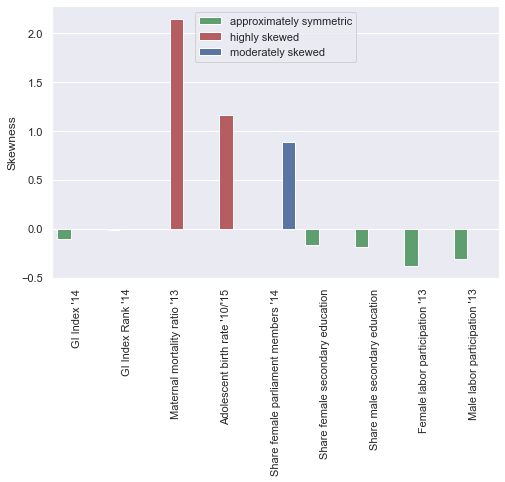

In [11]:
#Deskriptive Analyse

MICE_functions.get_datatype(dataset_name,basic_data_df, feature_matrix)
MICE_functions.get_skewness(basic_data_df, dataset_name, feature_matrix)

<p>We can see that most of the attributes are highly skewed. That might be a problem for some regression algorithms.</p>
<p>What about kurtosis?</p>

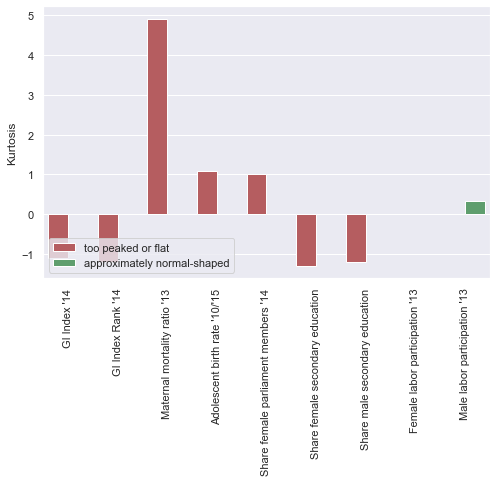

In [12]:
MICE_functions.get_kurtosis(basic_data_df, dataset_name, feature_matrix)

<p>Kurtosis looks even worse. Just two attributes are neither too skewed nor too peaked or flat.</p>
<p>Below we see the impact on the normality assumption:</p>

Columns ["GI Index '14", "GI Index Rank '14", "Maternal mortality ratio '13", "Adolescent birth rate '10/'15", "Share female parliament members '14", 'Share female secondary education', 'Share male secondary education'] are not normally distributed!

Columns ["Female labor participation '13", "Male labor participation '13"] are normally distributed!


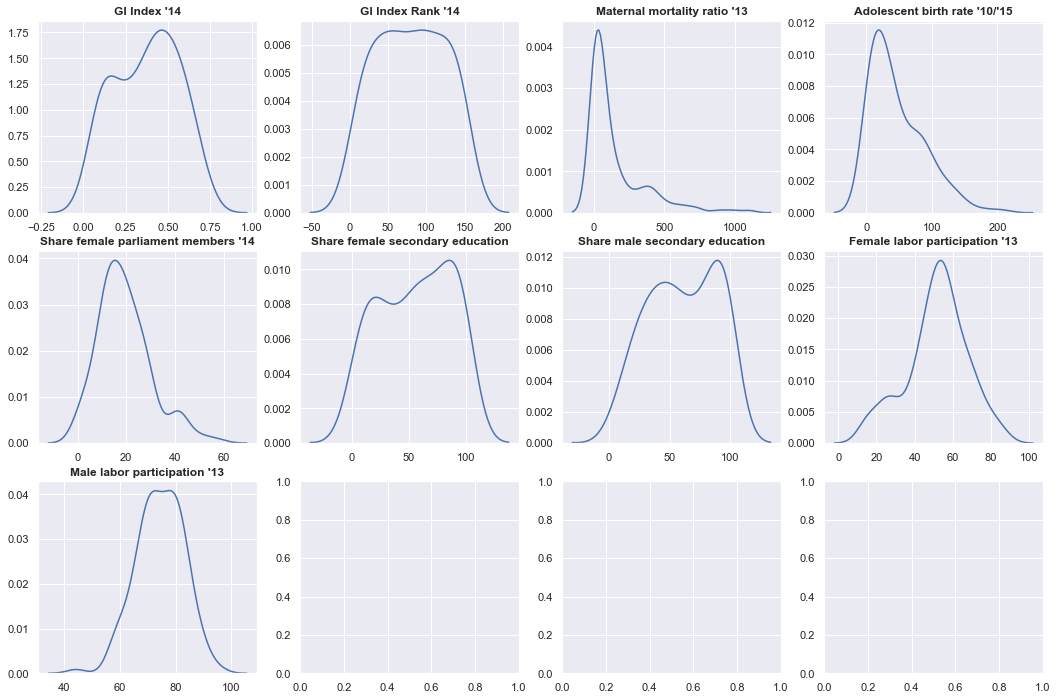

In [13]:
MICE_functions.normal_test(dataset_name, basic_data_df, feature_matrix)

<h3>Now that we have explored that datasets features, let's get to the imputations.</h3>

<p>Starting with Random Forests. Below a short view on the first 5 imputed values compared to the original one's.</p>

In [9]:
#Explorative Analyse

#data_imputed_RF=impute_RandomForest(data_missing, n_est)
data_RF=MICE_functions.impute_RandomForest(basic_data_df, data_missing, rnd_numbers_row, rnd_numbers_column, error_i, m,  n_est)
data_imputed_RF=data_RF[0]
compare_RF, imputed_df_final_RF=MICE_functions.compare_imp(basic_data_df, data_RF[1], rnd_numbers_row, rnd_numbers_column, error_i, 'Random Forest')

Imputed values - Random Forest: 

   True_value  Imputed_value
0        68.6        73.3685
1        43.6        45.6050
2        82.9        76.5845
3        41.3        41.8630
4        46.0        45.3350 




<p>And the same for Bayesian Ridge:</p>

In [10]:
data_Bayes=MICE_functions.impute_BayesRegression(basic_data_df, data_missing, rnd_numbers_row, rnd_numbers_column, error_i, m)
data_imputed_Bayes=data_Bayes[0]
compare_Bayes, imputed_df_final_BR=MICE_functions.compare_imp(basic_data_df, data_Bayes[1], rnd_numbers_row, rnd_numbers_column, error_i, 'Bayesian Ridge')

Imputed values - Bayesian Ridge: 

   True_value  Imputed_value
0        68.6      72.618628
1        43.6      45.101962
2        82.9      80.150996
3        41.3      40.146069
4        46.0      44.506936 




<p>To assess the imputation performance, NRMSE (normalized root mean squared error) is a good metric to compare residuals of different models for attributes on different scales.</p>
<p>The <b>lower</b> the NRMSE the <b>better</b> the imputation accuracy.</p>

In [11]:
nrmse_BR, nrmse_list_BR=MICE_functions.calc_nrmse(basic_data_df, imputed_df_final_BR, 'Bayesian Ridge')
nrmse_RF, nrmse_list_RF=MICE_functions.calc_nrmse(basic_data_df, imputed_df_final_RF, 'Random Forest')

NRMSE for Bayesian Ridge: 0.03222600298251785
NRMSE for Random Forest: 0.027649580172113702


<p>For this dataset, Random Forest is the better estimator!</p>
<h3>Let's have a look at the graphics for this result.</h3>

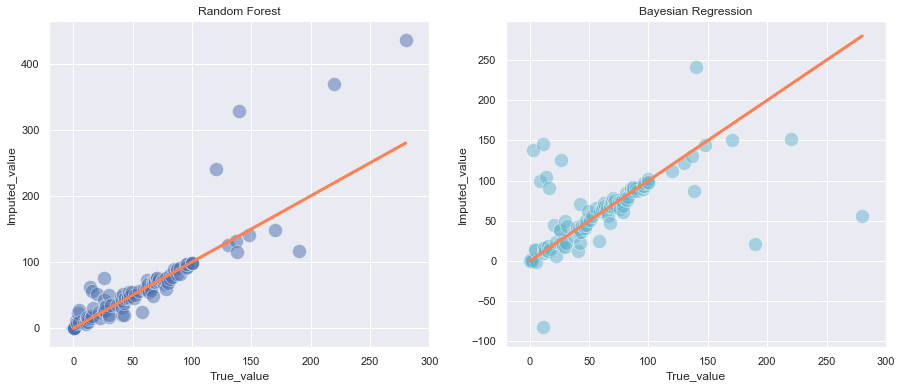

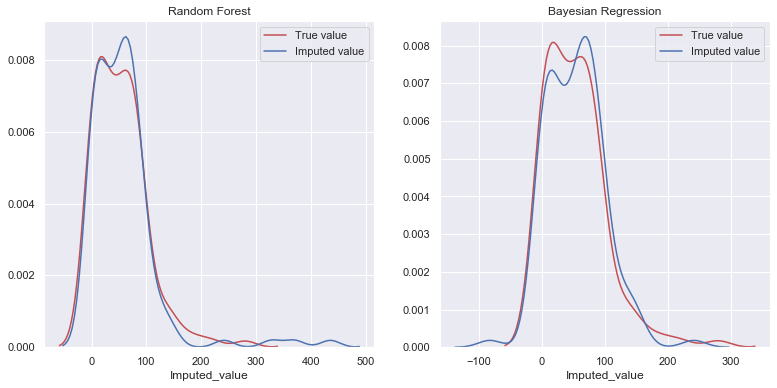

In [12]:
mann_whitney_value, mann_whitney_p=stats.mannwhitneyu(nrmse_list_BR, nrmse_list_RF, alternative='two-sided')

result_matrix=MICE_functions.calc_between_var(dataset_name, data_RF[1], 'RF', result_matrix)
result_matrix=MICE_functions.calc_between_var(dataset_name, data_Bayes[1], 'BR', result_matrix)


MICE_functions.scatterplot_imp(compare_RF, compare_Bayes)

In [ ]:
MICE_functions.distplot_imp(compare_RF, compare_Bayes)

<p>Both estimators did a good job for the majority of the data. For some of the extreme points, the estimations were rather off though.</p>

<h3>Which metafeatures did our dataset have?</h3>

In [13]:
MICE_functions.add_final_scores(dataset_name, nrmse_BR, nrmse_RF, mann_whitney_p, feature_matrix, result_matrix)
feature_matrix

,Dataset,pct_missing,n,Attributes,ratio_attributes to instances,pct_metric,pct_binary,pct_categorical,Mean of numeric values,Std of numeric values,Avg distinct values of categorical variables,pct_outliers,pct_normally distributed attributes,AVG Skewness,AVG Kurtosis,pct_highly correlated variables (>.4),Best estimator
0,Gender inequality,9.37,140,9,0.0643,100,0,0,59.77,43.36,0,1.9,22.22,0.5957,1.3484,27.78,No difference


<h3>What are the the results of imputation performance comparison?</h3>
<p>One of the main advantages of multiple imputation is that it takes the inherent uncertainties into account that estimation of unknown values bring about. The Between-Variance is therefore an important metric that should not be too low.</p>

In [15]:
result_matrix

,Dataset,NRMSE RF,NRMSE BR,Between-variance (z-score) RF,Between-variance (z-score) BR,p (Mann-Whitney-U)
0,Gender inequality,0.0276496,0.032226,0.825416,0.814353,0.536499


<h2>Can we derive common characteristics of dataset's metafeatures as indicators of model performance?</h2> 
<p>In order to answer this question, we load the results for all of the 20 examined datasets. Let's say for pct_missing = 10%.</p>

In [15]:
#Metafeatures matrix
feature_matrix=pd.read_csv('../data_results/feature_matrix_10pct.csv', index_col=0)
feature_matrix

,Dataset,pct_missing,n,Attributes,ratio_attributes to instances,pct_metric,pct_binary,pct_categorical,Mean of numeric values,Std of numeric values,Avg distinct values of categorical variables,pct_outliers,pct_normally distributed attributes,AVG Skewness,AVG Kurtosis,pct_highly correlated variables (>.4),Best estimator
0,Parkinson,9.54,195,23,0.1179,95.65,4.35,0.00,22.20,8.30,0,4.93,17.39,1.6969,5.5110,50.59,Bayesian Regression
1,Gender inequality,9.37,140,9,0.0643,100.00,0.00,0.00,59.77,43.36,0,1.90,22.22,0.5957,1.3484,27.78,No difference
2,Humor Styles,9.53,989,37,0.0374,10.81,0.00,89.19,3.02,1.08,4,2.31,2.70,0.4976,0.9196,7.21,Bayesian Regression
3,Long Beach,9.58,92,22,0.2391,36.36,31.82,31.82,3.29,3.99,10,6.13,9.09,1.8379,6.7495,2.16,No difference
4,NLS marital,9.54,6130,7,0.0011,0.00,0.00,100.00,0.94,0.82,4,26.76,0.00,1.6746,4.6961,52.38,No difference
5,NLS attended,9.53,18513,7,0.0004,100.00,0.00,0.00,13.05,4.35,0,3.42,0.00,12.4927,233.4655,100.00,No difference
6,NLS employment,9.57,11822,7,0.0006,0.00,0.00,100.00,2.05,1.74,7,13.69,0.00,1.1629,0.6948,38.10,No difference
7,Big Five,9.51,19231,52,0.0027,0.00,1.92,98.08,3.10,1.16,4,1.20,0.00,0.4966,0.7423,3.85,Random Forest
8,Cattell,9.52,6098,164,0.0269,0.00,0.00,100.00,3.14,1.08,4,2.73,0.00,0.4815,0.6982,1.50,Random Forest
9,Baltimore family health,9.27,41,5,0.1220,100.00,0.00,0.00,93.74,29.76,0,2.93,80.00,0.4962,0.7069,20.00,No difference


In [16]:
#Impuation performance comparison matrix
result_matrix=pd.read_csv('../data_results/result_matrix_10pct.csv', index_col=0)
result_matrix

,Dataset,NRMSE RF,NRMSE BR,Between-variance (z-score) RF,Between-variance (z-score) BR,p (Mann-Whitney-U)
0,Parkinson,0.035832,0.024004,0.803954,0.816796,2.503538e-02
1,Gender inequality,0.027610,0.032226,0.823745,0.814353,4.799287e-01
2,Humor Styles,0.058377,0.041124,0.820460,0.819650,1.145350e-06
3,Long Beach,0.064319,0.067266,0.771043,0.821245,8.972754e-01
4,NLS marital,0.031906,0.031435,0.756204,0.820680,1.000000e+00
5,NLS attended,0.005627,0.006284,0.805502,0.820653,5.229032e-01
6,NLS employment,0.066802,0.066783,0.809496,0.820753,8.983268e-01
7,Big Five,0.072089,0.075289,0.820901,0.820529,8.202291e-02
8,Cattell,0.064889,0.067080,0.820280,0.820662,3.570942e-02
9,Baltimore family health,0.068325,0.065701,0.806983,0.810882,8.345316e-01


<h3>How did the estimators perform over all of the 20 datasets?</h3>

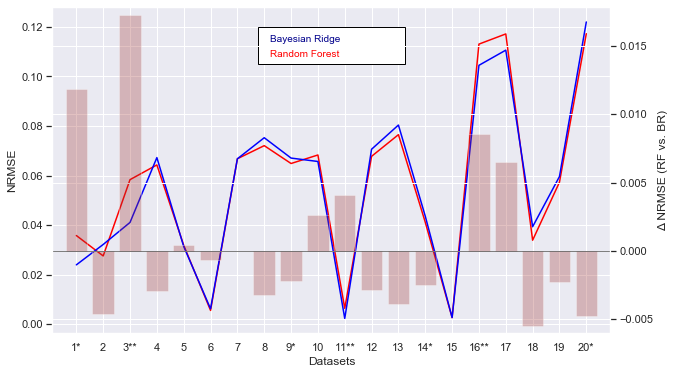

In [6]:
MICE_visualization.performance_overall(result_matrix)

<p>For some datasets, differences in accuracy have been significant. Those are marked with <b>*</b> for p $<$ 0.05 and with <b>**</b> for p $<$ 0.01.</p>
<p>Other datasets (especially no. 6, 11, 15) seem to be somewhat 'easier' to impute having overall low NRMSEs and show no difference in imputation performance.<br>These datasets are characterized by high portions of 'metric variables'.</p>

<h3>How do the results change for different fractions of missing values?</h3>

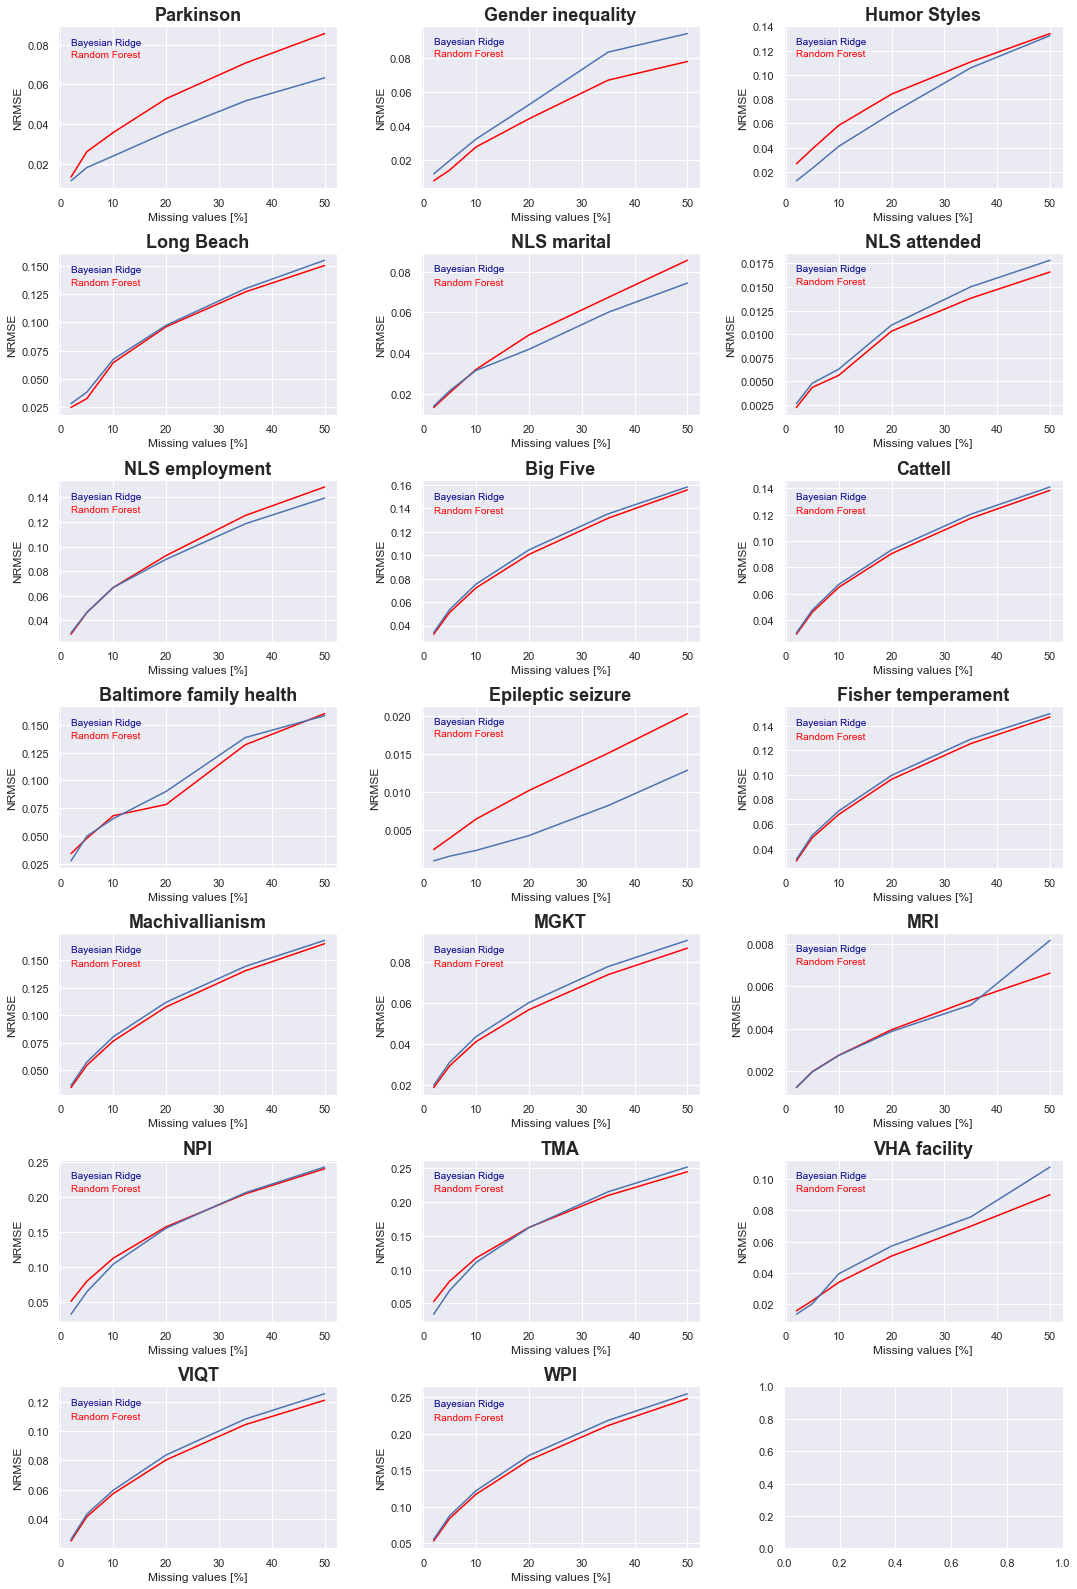

In [17]:
# Load all of the pre-calculated result datasets, join them and 
# plot imputation performance for each dataset separately
result_matrix_2=pd.read_csv('../data_results/result_matrix_2pct.csv', index_col=0)
result_matrix_5=pd.read_csv('../data_results/result_matrix_5pct.csv', index_col=0)
result_matrix_10=pd.read_csv('../data_results/result_matrix_10pct.csv', index_col=0)
result_matrix_20=pd.read_csv('../data_results/result_matrix_20pct.csv', index_col=0)
result_matrix_35=pd.read_csv('../data_results/result_matrix_35pct.csv', index_col=0)
result_matrix_50=pd.read_csv('../data_results/result_matrix_50pct.csv', index_col=0)
result_matrix_ges=pd.concat([result_matrix_2, result_matrix_5, result_matrix_10, result_matrix_20, result_matrix_35, result_matrix_50])
result_matrix_ges.reset_index(drop=True, inplace=True)

MICE_visualization.performance_per_pct_missing(result_matrix_ges)

<p>Three observations:</p>
<ol>
    <li>Imputation performance drops as missing values increase (which could be expected),</li>
    <li>Where imputation performance is equal for few missing values, it stays that way for increasing fractions,</li>
    <li>Where higher differences can be observed for few missing values, differences tend to be amplified with increasing missing values.</li></ol>
    
<p>So we can say that the importance of estimator selection in MICE increases with increasing occurrences of missing values.</p>

<h3>Which of the attributes have the most impact on relative imputation performance?</h3>

<p>It is good to know that the estimators performances differ for variations of metafeatures. For practical reasons it would be nice to know, which features exactly indicate the use of which estimator.</p>
<p>We perform another bayesian regression, this time on the feature matrix associated with the estimators that worked best for each dataset. The regression coefficients can be interpreted as relative weights of prediction for estimator superiority.</p>

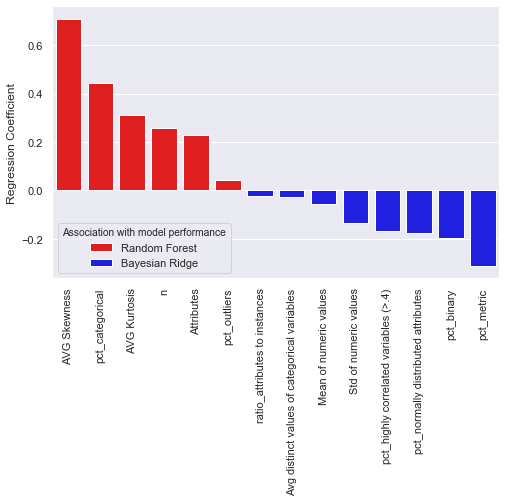

In [7]:
MICE_visualization.feature_weights(feature_matrix)

<p>Random Forests seem to perform better for large datasets, especially when normality cannot be assumed.<br>Bayesian Ridge Regression seems to work better on metric variables and in presence of multicollinearity (inter-correlated predictors).</p>
<p>It is important to point out that these results <b>seem</b> to allow for these conclusions. Due to the low sample of datasets, the regression coefficients cannot be tested for significance and do not allow for robust inferences.</p>

<h3>Further factors to be considered for model selection</h3>
<p>We now know that RF likely performs better for not-normally distributed data and BR should be used in cases of multicollinearity. Practical concern are often related to computation limitations. Is one of the estimators faster than the other?</p>

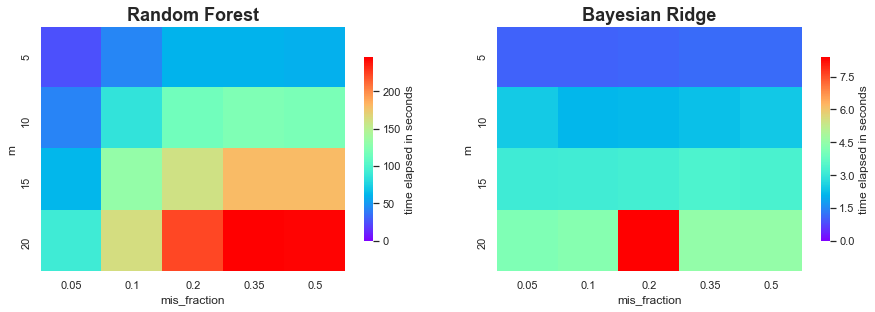

In [8]:
MICE_visualization.imputation_time(basic_data_df, feature_matrix, n_est, dataset_name)

<p>We can clearly see, that BR performs its imputations about 50 times faster than RF. Furthermore, BR is not dependent on the fraction of missing values whereas RF imputation time increases with more missing values.</p>

<h2>Conclusions</h2>
<p>Random Forest and Bayesian Ridge as estimators for MICE differ significantly in relative imputation performance depending on dataset metafeatures.<br>It can be inferred from the analyses that RF performs better with high dimensionality and violation of normality assumptions whereas BR is indicated in the presence of multicollinearity and "easy" cases where variables are on metric scales.</p>
<p>Concerning computational performance, BR is about 50 times faster than RF.</p>
<p>Thus, it can be recommended to use Bayesian Ridge Regression as a default estimator and turn towards Random Forest in cases where the normality assumption is heavily violated.</p>